In [64]:
import os
import glob
import datetime as dt
import numpy as np
import xarray as xr
import pandas as pd
from sublimpy import utils, extrautils
import matplotlib.pyplot as plt
import altair as alt
alt.data_transformers.enable('json')
import act
import swifter

## Open cross-valley/along-valley wind times

In [65]:
cross_valley_wind_times = pd.to_datetime(pd.read_csv('cross_valley_wind_times.csv')['0'])
along_valley_wind_times =  pd.to_datetime(pd.read_csv('along_valley_wind_times.csv')['0'])

# Prepare Surface Turbulence Measurements

## SOS

In [66]:
sos_tidy_fn = f"../paper1/process_slow_data/tidy_df_20221101_20230619_planar_fit_multiplane_q7_flags9000_pf10.parquet"
tidy_df = pd.read_parquet(sos_tidy_fn)
# Convert data timezone to local and clean up data on the ends
# convert time column to datetime
tidy_df['time'] = pd.to_datetime(tidy_df['time'])
tidy_df = utils.modify_df_timezone(tidy_df, 'UTC', 'US/Mountain')
# tidy_df = tidy_df[tidy_df.time > '20230301']
tidy_df = tidy_df[tidy_df.time > '20221221']
tidy_df.time.min(), tidy_df.time.max()

(Timestamp('2022-12-21 00:30:00'), Timestamp('2023-06-19 17:30:00'))

Isolate turbulence statistics

In [67]:
src = tidy_df[tidy_df.variable.isin([
    'tke_3m_c', 'spd_3m_c', 'w_h2o__3m_c', 'w_tc__3m_c', 'u_v__3m_c', 'u_w__3m_c', 'v_w__3m_c',
    'tke_20m_c', 'spd_20m_c', 'w_h2o__20m_c', 'w_tc__20m_c', 'u_v__20m_c', 'u_w__20m_c', 'v_w__20m_c',
    'spd_3m_d', 'spd_3m_uw', 'spd_3m_ue',
    'tke_3m_d', 'tke_3m_uw', 'tke_3m_ue',
])].pivot(index='time', columns='variable', values='value')
src['Vtke_3m_c'] = src['tke_3m_c']**0.5
src['Vtke_3m_d'] = src['tke_3m_d']**0.5
src['Vtke_3m_uw'] = src['tke_3m_uw']**0.5
src['Vtke_3m_ue'] = src['tke_3m_ue']**0.5
src['hourofday'] = src.index.hour

array([<Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>], dtype=object)

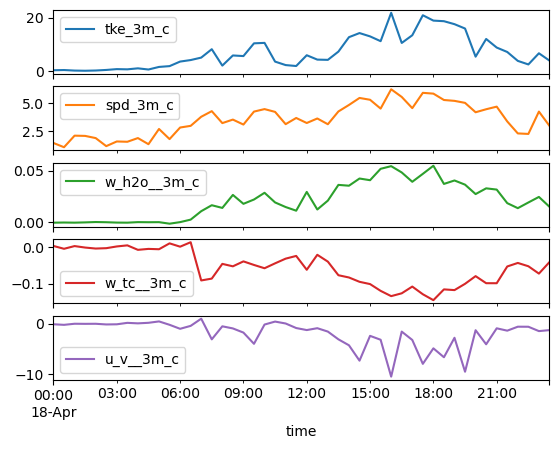

In [68]:
src.loc['20230418'][
    ['tke_3m_c', 'spd_3m_c', 'w_h2o__3m_c', 'w_tc__3m_c', 'u_v__3m_c']
].plot(subplots=True)

## SAIL

# Plot V_tke vs wind speed - identify top-down turbulence

In [69]:
alt.Chart(src.loc['20221222']).mark_text(color='blue').encode(
    alt.X('spd_3m_c:Q'),
    alt.Y('Vtke_3m_c:Q'),
    alt.Text('hourofday:O'),
).properties(width=200, height = 200) +\
alt.Chart(src.loc['20230418']).mark_text(color='red').encode(
    alt.X('spd_3m_c:Q'),
    alt.Y('Vtke_3m_c:Q'),
    alt.Text('hourofday:O'),
).properties(width=200, height = 200) +\
alt.Chart(src.loc['20230409']).mark_text(color='black').encode(
    alt.X('spd_3m_c:Q'),
    alt.Y('Vtke_3m_c:Q'),
    alt.Text('hourofday:O'),
).properties(width=200, height = 200) 

alt.LayerChart(...)

In [70]:
alt.Chart(
    tidy_df.query("tower == 'c'").query("measurement == 'wind speed'").set_index('time').loc['20230418'].reset_index()
).mark_line().encode(
    alt.X('mean(value):Q'),
    alt.Y('height:Q'),
    alt.Facet('hours(time):T', columns=4),
    order='height'
).properties(width=100, height=100)

alt.Chart(...)

In [71]:
base = alt.Chart().mark_text().encode(
        alt.X('spd_3m_c:Q').scale(domain=[0, 10], clamp=True),
        alt.Y('Vtke_3m_c:Q'),
        alt.Text('hourofday:O'),
        alt.Facet('date(time):T', columns=5)
    ).properties(width=200, height = 200)

(
    alt.hconcat(base, data=src.loc['20221221': '20221222'].reset_index()).resolve_scale(x='shared', y='shared') &\
    alt.hconcat(base, data=src.loc['20230218': '20230219'].reset_index()).resolve_scale(x='shared', y='shared') &\
    alt.hconcat(base, data=src.loc['20230305': '20230307'].reset_index()).resolve_scale(x='shared', y='shared') &\
    alt.hconcat(base, data=src.loc['20230418': '20230419'].reset_index()).resolve_scale(x='shared', y='shared')
).resolve_scale(x='shared', y='shared')

alt.VConcatChart(...)

In [72]:
alt.Chart(
    src.loc['20230401': '20230430'].reset_index()
).mark_text().encode(
    alt.X('spd_3m_c').scale(domain=[0, 10], clamp=True),
    alt.Y('Vtke_3m_c:Q'),
    alt.Text('hourofday'),
    # alt.Color('hourofday:Q').scale(scheme='rainbow'),
    alt.Facet('date(time)', columns=5)
).properties(width=200, height = 200)

alt.Chart(...)

In [73]:
base = alt.Chart(pd.concat([
        src.loc['20230409'].reset_index(),
        src.loc['20230418'].reset_index()
])).mark_circle().encode(    
    alt.Color('date(time):N'),
).properties(width=200, height = 200)

(base.encode(
    alt.X('spd_3m_c').scale(domain=[0, 10], clamp=True), alt.Y('Vtke_3m_c'),
) | base.encode(
    alt.X('spd_3m_d').scale(domain=[0, 10], clamp=True), alt.Y('Vtke_3m_d'),
) | base.encode(
    alt.X('spd_3m_ue').scale(domain=[0, 10], clamp=True), alt.Y('Vtke_3m_ue'),
) | base.encode(
    alt.X('spd_3m_uw').scale(domain=[0, 10], clamp=True), alt.Y('Vtke_3m_uw'),
)).resolve_scale(x='shared', y='shared')

alt.HConcatChart(...)

In [74]:
src = tidy_df[tidy_df.variable.isin([
    'tke_3m_c', 'spd_3m_c', 'w_h2o__3m_c', 'w_tc__3m_c', 'u_v__3m_c', 'u_w__3m_c', 'v_w__3m_c',
    'tke_20m_c', 'spd_20m_c', 'w_h2o__20m_c', 'w_tc__20m_c', 'u_v__20m_c', 'u_w__20m_c', 'v_w__20m_c'
])].pivot(index='time', columns='variable', values='value')

src = pd.concat([
        src[src.index.isin(cross_valley_wind_times)].assign(synoptic_wind = 'cross valley'),
        src[src.index.isin(along_valley_wind_times)].assign(synoptic_wind = 'along valley')
    ])
src['Vtke'] = src['tke_3m_c']**0.5
base_chart = alt.Chart(
    src
).mark_circle(size=5, color='orange').encode(
    alt.Color('synoptic_wind:N')
).properties(width=200, height = 200)

In [75]:
(
    base_chart.encode(      alt.X('spd_3m_c').scale(domain=[0, 10], clamp=True),     y='Vtke')
    | base_chart.encode(    alt.X('spd_3m_c').scale(domain=[0, 10], clamp=True),     y='u_w__3m_c') 
    | base_chart.encode(    alt.X('spd_3m_c').scale(domain=[0, 10], clamp=True),     y='v_w__3m_c') 
    | base_chart.encode(    alt.X('spd_3m_c').scale(domain=[0, 10], clamp=True),     y='u_v__3m_c') 
) & (
    base_chart.encode(      alt.X('spd_20m_c').scale(domain=[0, 10], clamp=True),    y='Vtke')
    | base_chart.encode(    alt.X('spd_20m_c').scale(domain=[0, 10], clamp=True),    y='u_w__20m_c') 
    | base_chart.encode(    alt.X('spd_20m_c').scale(domain=[0, 10], clamp=True),    y='v_w__20m_c') 
    | base_chart.encode(    alt.X('spd_20m_c').scale(domain=[0, 10], clamp=True),    y='u_v__20m_c') 
)

alt.VConcatChart(...)

In [76]:
src['spd bin'] = pd.cut(
    src['spd_3m_c'], 
    np.arange(0,11), 
    # labels = [f"{lo}-{hi}" for lo, hi in zip(np.arange(0,11), np.arange(1,11))]
    labels = [(lo + hi)/2 for lo, hi in zip(np.arange(0,11), np.arange(1,11))]
)


In [77]:
turbulence_regime_box_chart = alt.Chart(
    src
).mark_boxplot(outliers=False, opacity=0.5, box={'stroke': 'black'}).encode(
    alt.X('spd bin:Q').title('3m wind speed (m/s)'),
    alt.Y('Vtke:Q'),
    alt.Color('synoptic_wind:N'),
).properties(width=200, height = 200)
turbulence_regime_box_chart

alt.Chart(...)

# Local Scaling - does MOST work ?

Calculate dimensionless wind gradient (stability correction) and the stability function (z/L)

In [78]:
# src = tidy_df [tidy_df.time > '20230415'][tidy_df.time < '20230418']
HEIGHT = 3
src = tidy_df.copy()
src = src[src.variable.isin([
    'u*_3m_c', 'spd_3m_c', 'L_3m_c', 'Tvirtual_3m_c', 'w_tc__3m_c', 'wind_gradient_3m_c', 'temp_gradient_3m_c'
])]
src = src.pivot_table(values='value', columns='variable', index='time')
src['L_3m_c'] = - (src['u*_3m_c']**3)*(src['Tvirtual_3m_c']+273.5) / (0.4 * 9.81 * src['w_tc__3m_c'])
src['z_over_l'] = HEIGHT / src['L_3m_c']
src['stability_correction'] = 0.4*HEIGHT*src['wind_gradient_3m_c']/src['u*_3m_c']

src_along_valley_times = src[src.index.isin(along_valley_wind_times)]
src_cross_valley_times = src[src.index.isin(cross_valley_wind_times)]

Create a fit line for a couple different stability corrections

In [79]:
def holtslag_and_debruin(zeta):
    return (
        1 + 0.7*zeta + 0.75*zeta*(6 - 0.35*zeta)*np.exp(-0.35*zeta)
    )
def lettau(zeta):
    return (1 + 4.5*zeta)**0.75
fits_domain_stable = pd.Series(np.linspace(0,2))
fits_domain_unstable = pd.Series(np.linspace(-2,0))
fits_df = pd.concat([
    pd.DataFrame({
        'z_over_l': fits_domain_stable,
        'stability_correction': fits_domain_stable.apply(lettau),
    }),
    pd.DataFrame({
        'z_over_l': fits_domain_unstable,
        'stability_correction': (1 - 15 * fits_domain_unstable)**(-0.25)
    })
])

In [80]:
alt.Chart(
    src
).mark_circle(size=2).encode(
    alt.X('z_over_l').scale(domain=[-2, 2], clamp=True),
    alt.Y('stability_correction').scale(domain=[0, 6], clamp=True)
).properties(title='All data') +\
    alt.Chart(fits_df).mark_line(color='red').encode(
    alt.X('z_over_l:Q'),
    alt.Y('stability_correction:Q')
).properties(width=250, height = 250)

alt.LayerChart(...)

In [81]:
y_max = 3.5
x_min = -1.0
x_max = 1.0
scatter_chart_base = alt.Chart(
).mark_circle(size=10).encode(
    alt.X('z_over_l').scale(domain=[x_min, x_max], clamp=True),
    alt.Y('stability_correction').scale(domain=[0, y_max], clamp=True)
).properties(title='All data') +\
    alt.Chart(fits_df).mark_line(color='red').encode(
    alt.X('z_over_l:Q').scale(domain=[x_min, x_max], clamp=True),
    alt.Y('stability_correction:Q').scale(domain=[0, y_max], clamp=True)
).properties(width=250, height = 250)

alt.layer(scatter_chart_base, 
    data=src_along_valley_times.query(f"z_over_l < {x_max}").query(f"z_over_l > {x_min}").query("stability_correction > 0").query(f"stability_correction < {y_max}")
).properties(title='Along valley winds') | alt.layer(scatter_chart_base, 
    data=src_cross_valley_times.query(f"z_over_l < {x_max}").query(f"z_over_l > {x_min}").query("stability_correction > 0").query(f"stability_correction < {y_max}")
).properties(title='Cross valley winds')

alt.HConcatChart(...)

In [82]:
import altair as alt

# Define the base chart for 2D histograms
histogram_base = alt.Chart().mark_rect().encode(
    alt.X('z_over_l:Q', bin=alt.Bin(step=0.1), scale=alt.Scale(domain=[-1, 1], clamp=True)),
    alt.Y('stability_correction:Q', bin=alt.Bin(step=0.1), scale=alt.Scale(domain=[0, 3], clamp=True)),
    alt.Color('count():O')
).properties(width=250, height=250)

# Create the line chart for fits_df
line_chart = alt.Chart(fits_df).mark_line(color='red').encode(
    alt.X('z_over_l:Q'),
    alt.Y('stability_correction:Q')
)

# Combine the histograms and line chart
chart_along_valley = alt.layer(histogram_base, line_chart, data=src_along_valley_times).properties(title='Along valley winds')
chart_cross_valley = alt.layer(histogram_base, line_chart, data=src_cross_valley_times).properties(title='Cross valley winds')

# Display the charts side by side
chart_along_valley | chart_cross_valley

alt.HConcatChart(...)

In [83]:
combo_df = pd.concat([
    # src.query("z_over_l < 2").query("z_over_l > -2").query("stability_correction < 10").assign(category = 'all data'),
    src_along_valley_times.query("z_over_l < 2").query("z_over_l > -2").query("stability_correction < 10").assign(category = 'along valley'),
    src_cross_valley_times.query("z_over_l < 2").query("z_over_l > -2").query("stability_correction < 10").assign(category = 'cross valley'),
])

(
    # case study plot
    ####################################
    alt.Chart(
        pd.concat([
            src.loc['20230409'],
            src.loc['20230418']
        ]).reset_index().query("z_over_l < 2")
    ).mark_circle(opacity=.5).encode(
        alt.X('z_over_l').scale(domain=[-2, 2], clamp=True),
        alt.Y('stability_correction').scale(domain=[0, 6], clamp=True),
        alt.Color('date(time):N')
    ) +\
        alt.Chart(fits_df).mark_line(color='red').encode(
        alt.X('z_over_l:Q'),
        alt.Y('stability_correction:Q')
    ).properties(title='Two days in April')
    
    # summary study plot
    ####################################
    |
    (alt.Chart(
        combo_df
    ).mark_circle().encode(
        alt.X('z_over_l:Q').bin(step=0.4).axis(values=[-2,-1,0,1,2], format='.0f', tickCount=5),
        alt.Y('median(stability_correction):Q'),
        alt.Color('category:N'),
    ) + alt.Chart(fits_df).mark_line(color='red').encode(
        alt.X('z_over_l:Q'),
        alt.Y('stability_correction:Q')
    )).properties(title='All Data') 

).resolve_scale(color='independent').display(renderer='svg')

alt.HConcatChart(...)